In [77]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader
from tqdm import trange

from datasets.SP100Stocks import SP100Stocks
from notebooks.models import A3TGCN, TGCN

In [78]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# Stock prices forecasting
The goal of this task is to predict the (normalized) price at the timestep $t+1$ for each stock in the S&P 100 index. For this task, a Temporal Graph Convolutional Network ([T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://arxiv.org/pdf/1811.05320)) is used. It consists of a GCN encoder followed by a GRU decoder. The encoder is used to learn the representation of the graph at each timestep, while the decoder is used to predict the variation at the next timestep.

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [79]:
dataset = SP100Stocks()
dataset, dataset[0]

(SP100Stocks(1208),
 Data(x=[100, 7, 25], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460], close_price=[100, 25], close_price_y=[100, 1]))

In [80]:
train_part = .9
batch_size = 64

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 1087, Test dataset: 121


## Training
An A3T-GCN model previously implemented is used. The model is trained using the training dataset and the Adam optimizer. The `weight_decay` parameter is used for L2 regularization, to follow the T-GCN papers methodology. The loss is calculated using the Mean Squared Error (MSE) loss function.

In [81]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int) -> tuple[list, list]:
	writer = SummaryWriter(f'runs/PriceForecasting_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
	for epoch in (pbar := trange(num_epochs, desc="Epochs")):
		for idx, data in enumerate(train_dataloader):
			optimizer.zero_grad()
			out = model(data.x, data.edge_index, data.edge_weight)
			loss = criterion(out, data.y)
			loss.backward()
			optimizer.step()
			pbar.set_postfix({"Loss": loss.item(), "Batch": f"{idx / len(train_dataloader) * 100:.1f}%"})
			writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
		for idx, data in enumerate(test_dataloader):
			out = model(data.x, data.edge_index, data.edge_weight)
			loss = criterion(out, data.y)
			writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)

In [82]:
in_channels, out_channels, hidden_size = dataset[0].x.shape[-2], 1, 32
model = TGCN(in_channels, out_channels, hidden_size)
model

TGCN(
  (cell): TGCNCell(
    (gcn): GCN(
      (convs): ModuleList(
        (0): GCNConv(7, 32)
        (1): GCNConv(32, 32)
      )
    )
    (lin_u): Linear(in_features=64, out_features=32, bias=True)
    (lin_r): Linear(in_features=64, out_features=32, bias=True)
    (lin_c): Linear(in_features=64, out_features=32, bias=True)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [83]:
lr, weight_decay, num_epochs = 0.002, 1e-5, 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [84]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs)

Epochs: 100%|██████████| 10/10 [06:30<00:00, 39.04s/it, Loss=0.367, Batch=94.1%]


## Results
The model tries to forecast the variations one timestep ahead for four stocks. The real values are plotted against the forecasted values.

### Results on train data

In [89]:
train_predictions = np.array([
	model(g.x, g.edge_index, g.edge_weight).detach().numpy() for g in train_dataloader
][:-1]).reshape(((len(train_dataloader) - 1) * train_dataloader.batch_size, -1))
train_targets = np.array([g.y.numpy() for g in train_dataloader][:-1]).reshape(((len(train_dataloader) - 1) * train_dataloader.batch_size, -1))

MSE = np.mean((train_predictions - train_targets) ** 2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(train_predictions - train_targets))

print(f"Mean Squared Error: {MSE:.4f}, Root Mean Squared Error: {RMSE:.4f}, Mean Absolute Error: {MAE:.4f}")

Mean Squared Error: 1.4091, Root Mean Squared Error: 1.1871, Mean Absolute Error: 0.9634


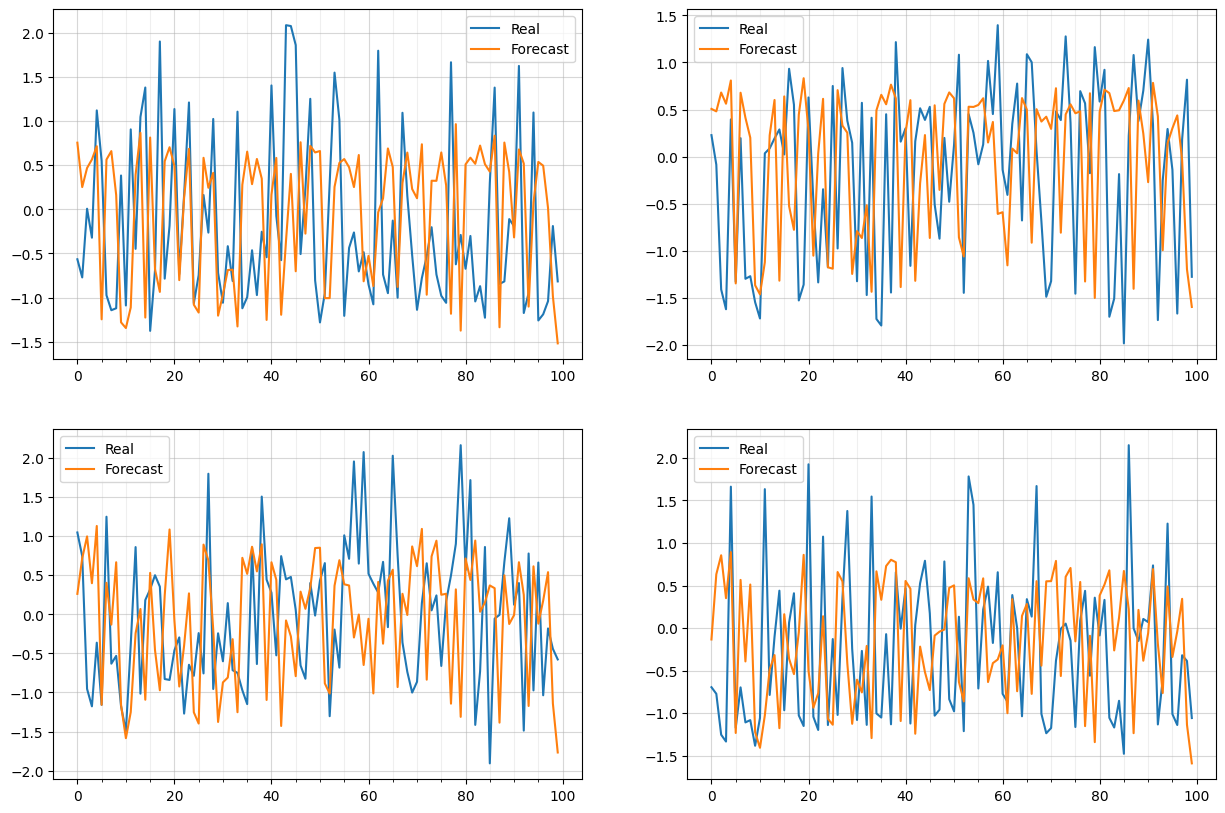

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
stocks_idx = np.random.choice(train_predictions.shape[1], 4)
n = 100
for idx, stock_idx in enumerate(stocks_idx):
	axs[idx // 2, idx % 2].plot(train_targets[:, stock_idx][n:2 * n], label="Real")
	axs[idx // 2, idx % 2].plot(train_predictions[:, stock_idx][n:2 * n], label="Forecast")
	axs[idx // 2, idx % 2].legend()
	axs[idx // 2, idx % 2].set_xticks(range(0, n, 5), minor=True)
	axs[idx // 2, idx % 2].grid(which='minor', alpha=0.2)
	axs[idx // 2, idx % 2].grid(which='major', alpha=0.5)

plt.show()

### Results on test data

In [91]:
test_predictions = np.array([
	model(g.x, g.edge_index, g.edge_weight).detach().numpy() for g in test_dataloader
]).reshape((len(test_dataloader) * test_dataloader.batch_size, -1))
test_targets = np.array([g.y.numpy() for g in test_dataloader]).reshape((len(test_dataloader) * test_dataloader.batch_size, -1))

MSE = np.mean((test_predictions - test_targets)**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(test_predictions - test_targets))

print(f"Mean Squared Error: {MSE:.4f}, Root Mean Squared Error: {RMSE:.4f}, Mean Absolute Error: {MAE:.4f}")

Mean Squared Error: 0.7644, Root Mean Squared Error: 0.8743, Mean Absolute Error: 0.7005


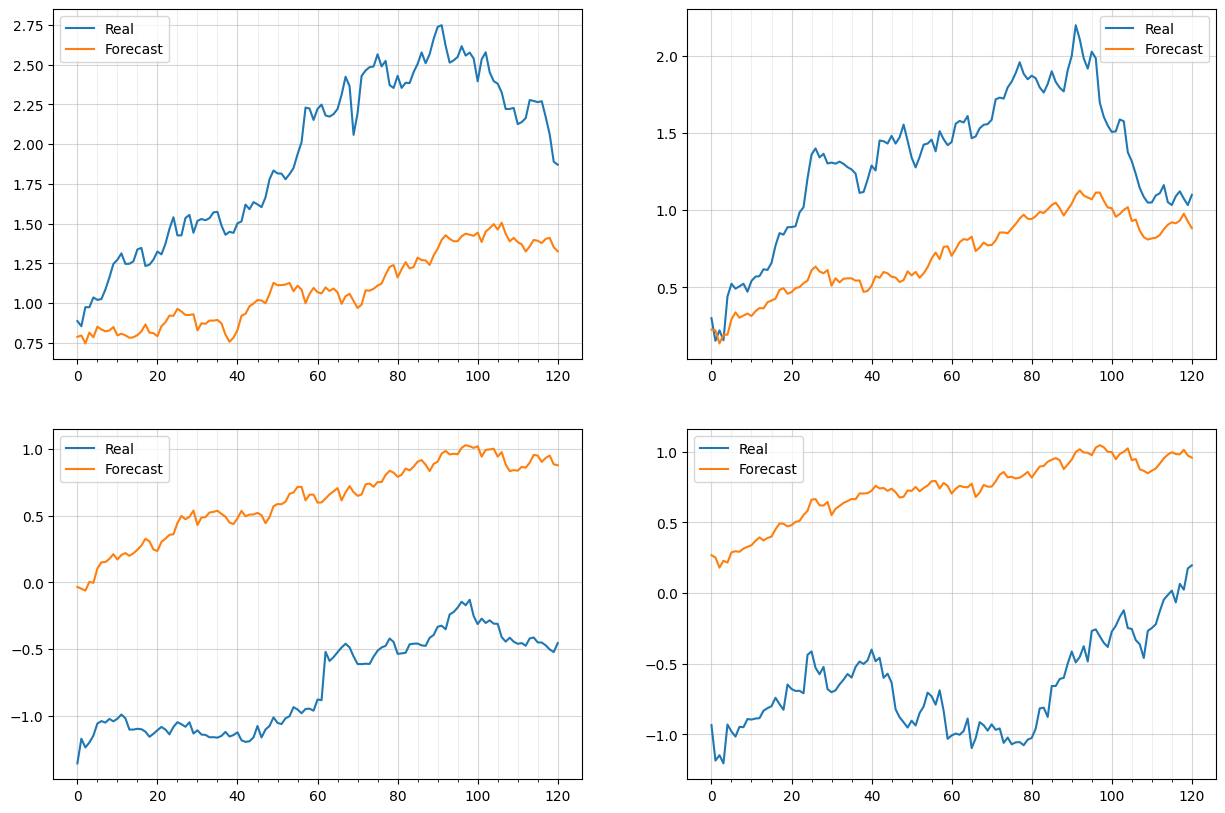

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
stocks_idx = np.random.choice(test_targets.shape[1], 4)
for idx, stock_idx in enumerate(stocks_idx):
	axs[idx // 2, idx % 2].plot(test_targets[:, stock_idx], label="Real")
	axs[idx // 2, idx % 2].plot(test_predictions[:, stock_idx], label="Forecast")
	axs[idx // 2, idx % 2].legend()
	axs[idx // 2, idx % 2].set_xticks(range(0, len(test_dataloader) * test_dataloader.batch_size, 5), minor=True)
	axs[idx // 2, idx % 2].grid(which='minor', alpha=0.2)
	axs[idx // 2, idx % 2].grid(which='major', alpha=0.5)
	
plt.show()